---

# Practical Machine Learning with Python
# Chapter 3: Classification
## Guillermo Avendaño-Franco  and Aldo Humberto Romero
## West Virginia University

### Machine Learning Workshop 2019

---

This notebook is based on a variety of sources, usually other notebooks, the material was adapted to the topics covered during lessons. In some cases, the original notebooks were created for Python 2.x or older versions of Scikit-learn or Tensorflow and they have to be adapted. 

## References

### Books

 * **Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems**, 1st Edition *Aurélien Géron*  (2017)

 * **Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow**, 2nd Edition, *Sebastian Raschka* and *Vahid Mirjalili* (2017)

 * **Deep Learning: A Practitioner's approach**, *Josh Patterson* and *Adam Gibson* 
 
 * **Deep Learning**, *Ian Goodfelow*, *Yoshua Bengio* and *Aaron Courville* (2016)

### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelein Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml)
   [Second Edition (In preparation)](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 

## Setup

This Jupyter notebook was created to run on a Python 3 kernel. Some Ipython magics were used: 

In [5]:
# commands prefaced by a % in Jupyter are called "magic"
# these "magic" commands allow us to do special things only related to jupyter

# %matplotlib inline - allows one to display charts from the matplotlib library in a notebook
# %load_ext autoreload - automatically reloads imported modules if they change
# %autoreload 2 - automatically reloads imported modules if they change
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-07-29T14:40:14-04:00

CPython 3.7.3
IPython 5.8.0

compiler   : GCC 8.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

In [8]:
%watermark -iv

sklearn    0.20.2
matplotlib 3.0.2
IPython    5.8.0
numpy      1.16.2



# Where we are in the map?

<img src="fig/ml_map.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Classification 

Classification and Regression are the foundations of many of the algorithms for Machine Learning, particular supervised learning. In this case the problem is to identify to which class or category new data belongs once we have trained the model with a set of data for which we know the output labels.

In machine learning and statistics, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known.

The following exercise provide a nice introduction to many of the relevant concepts in classification, some of them still valid when move into the prediction of continuum values in regression problems.

# MNIST database

The MNIST database of handwritten digits, available from the link below, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting

Many methods have been tested with this training set and test set. For more information about the original datasets from NIST see [Yann LeCun Website](http://yann.lecun.com/exdb/mnist/)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".", cache=True)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Each image is a vector with 784 components corresponding to a matrix 28 x 28

In [5]:
28 * 28

784

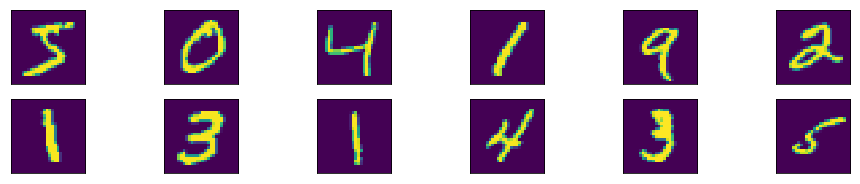

In [6]:
# Number of Rows
rgrid=2
# Number of Columns
cgrid=6
fig, axes = plt.subplots(rgrid,cgrid, figsize=(16,3))
for i in range(rgrid):
    for j in range(cgrid):
        #print(i,j,cgrid*i+j)
        axes[i,j].imshow(X[cgrid*i+j].reshape(28,28))
        axes[i,j].xaxis.set_ticks_position('none')
        axes[i,j].yaxis.set_ticks_position('none')
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])

In [7]:
y[:12].reshape(2,6)

array([['5', '0', '4', '1', '9', '2'],
       ['1', '3', '1', '4', '3', '5']], dtype=object)

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

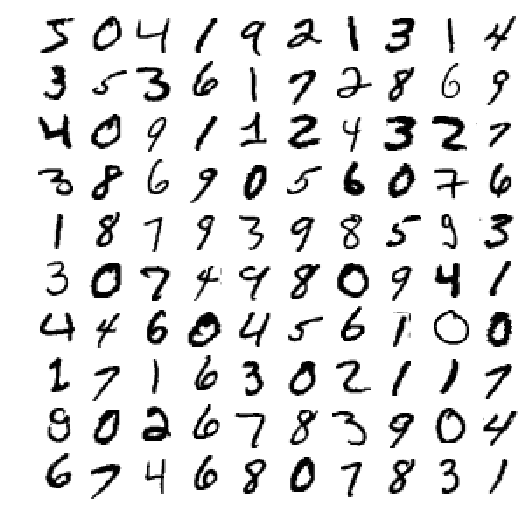

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

In [12]:
y[0]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier

Later we will attack the problem of classify all the ten digits. For now lets focus on a more modest classification problem, where we will try to identify if a given number is 5 or not.

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

There are several classifiers implemented in Scikit-Learn, the Stochastic gradient descent (SGD) `SGDClassifier` is a simple yet very efficient approach to fit linear models. While SGD is in reality an iterative method used to optimize the solution in an objective function with smooth properties but doing that stochastically, the classifier with SGD uses this method but now with a regularized linear model. 
It is particularly useful when the number of samples (and the number of features) is very large as it does not need to have the whole database in RAM. This process is then obtained by following the negative gradient of the objective after seeing only a single or a few training data. 

A nice discussion on the Stochastic gradient descent can be found at [SGD site](https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/), where we have taken the figures below. Left hand side represents a batch gradient descent where a batch of random data is used and right hand side is the stochastic gradient descent where a single random sample has been used for each step.

<table><tr><td><img src='fig/gdp.png' alt="Batch Gradient Descent" style="width:60%"></td><td><img src='fig/gdp-1.jpg' alt="Stochastic Gradient Descent" style="width:60%"></td></tr></table>
</a>

Right now the point is to get a black box that do classification for us.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict(X_train[:12])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [17]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

We can see that indeed the classifier seems to work fine. How to quantify that?

## Accuracy

The first measure will be accuracy, the total number of right answers versus the total number of misses

\begin{equation}
accuracy = \frac{\text{Total number of right answers}}{\text{Total number of cases}}
\end{equation}

We can do that for several subsets of the train set, in what is called **cross validation**

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96355, 0.93795, 0.95615])

However, we can create a new classifier that always answers negatively no matter what vector is presented.

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

We got 90% accuracy, which is consistent with a set of many cases where each digit is represented with the same frequency than any other.

## Confusion matrix

A better way of looking at the performance of a classifier is via the confusion matrix. A matrix that for each instace can be divided into 4 sets

 * **True positives** Images that are 5s and were identified as 5s
 * **True negatives** Images that are NOT 5s and were identified as NOT 5s
 * **False positives** Images that are NOT 5s but were identified as 5s
 * **False negatives** Images that are 5s but were identified as NOT 5s

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred = sgd_clf.predict(X_train)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53136,  1443],
       [  923,  4498]])

A perfect confusion matrix will look like this:

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision, Recall and F1

<img src="fig/Precision_Recall.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

Instead of using the **accuracy** a better metric could be use the precision and recall as defined by:

\begin{equation}
precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\end{equation}

---

\begin{equation}
recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{equation}

Finally there is one metric that measures the balance between precision and recall

\begin{equation}
F_1 = \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
\end{equation}


In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7571115973741794

In [25]:
# TP = 4820
# FP = 2263
4820 / (4820 + 2263)

0.6805026118876183

In [26]:
recall_score(y_train_5, y_train_pred)

0.829736211031175

In [27]:
# TP = 4820
# FN = 601
4820 / (4820 + 601)

0.8891348459693783

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7917620137299771

In [29]:
4820 / (4820 + (601 + 2263) / 2)

0.7709532949456174

### Decision Function

Scikit-learn provides a function to show the value that the SGD assign to each set of inputs. See for example the first 12

In [30]:
y_scores = sgd_clf.decision_function(X_train[:12])
y_scores

array([  2412.53175101, -15974.85481158, -21962.79731631, -11476.74060492,
        -9847.23205065, -11449.21117803,  -5519.07724093, -13646.93976857,
        -1413.36490829,  -6857.50566906,  -8669.55876894,   2494.84714339])

Notice that images indentified with 5 received positive score and other numbers received negative scores.

In [31]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

## Changing the threshold 

one interesting observation is to notice that if by any means we could change the threshold of acceptance for considering a image a 5 we increase the precision (by reducing FP) but at expenses of also reducing the recall (by also increasing the FN). In summary precision and recall are two conflicting quantities.

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

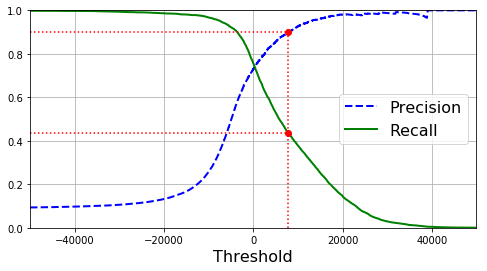

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown


In [38]:
(y_train_pred == (y_scores > 0)).all()

False

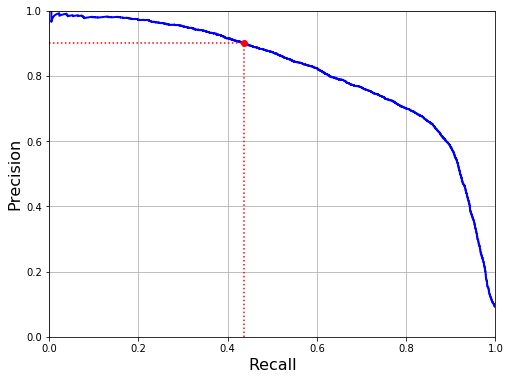

In [39]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro");

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [41]:
threshold_90_precision

7816.155523682527

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000380083618396

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.4368197749492714

# ROC curves

The Receiver Operating Characteristic (ROC) is a plot of recall (also known as *True Positive Rate*) against False Positive Rate (FPR) that is one minus the True Negative Rate (TNR) (Negative instances correctly indentified as negative)

 * FPR = 1 - TNR = 1 - specificity
 * TPR = Recall = sensitivity

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

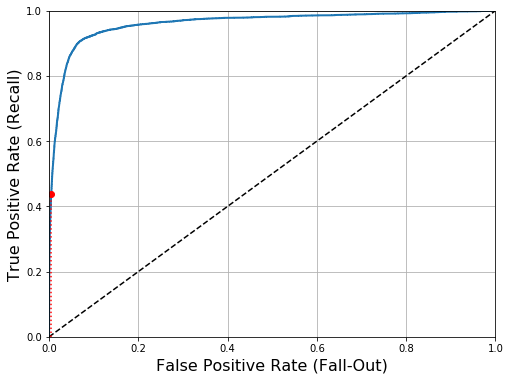

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9611778893101814

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [48]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [49]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

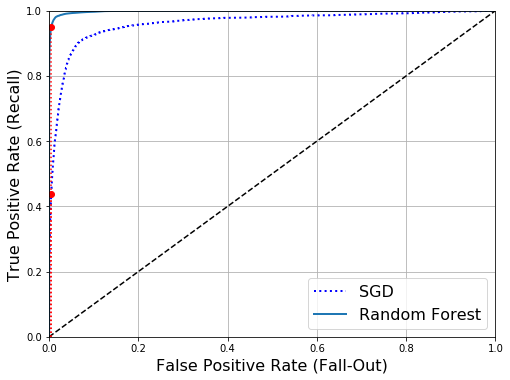

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [52]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [53]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass classification

The case until now was a binary classifier, but the MNIST is actually a multiclass classification problem.
Therefore, the goal is to construct a function which, given a new data point, will correctly predict the class to which the new data belongs. 

There are several Multiclass classifiers in Scikit-learn. Some are binary, others are directly multiclass as for example KNN, decision trees, neural networks, logistic regression, Naive Bayes, 

The simplest would be the OVA method (one vs all), which basically treat the multiclass classification as a set of binary classification. Here we train each binary classifier independently to solve the binary task. A simple example is seen in the left hand side of figure below. Each figure corresponds to a single class.   

Note: depending on the binary classifier is set up, there is a change that you get contradictory results, specially if you have imbalance data. If that happens, it is a good idea to use a discriminant function or using the loss function. A nice intro about this idea can be found in [Loss function description](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23).

The other possibility is to use one-to-one classification, which basically consider all possible pairs, as depicted on the center in the figure below. Here the benefit is that the training set is smaller, though there is a larger number of classifiers. Though, it seems that you have to do more work, it is not the case, as the classification for each pair is much smaller, which can be easily paralellized.

Another method, is the so called **error correcting output codes**, which is one of the most used methods nowadays, and it is an ensemble method. First of all a code matrix is created, which is a binary representation for each one of the classes, each code is different for each class and the binary representation is also called codeword. The next step is to use several binary classification algorithms on the same data, where each outcome is a binary value. These binary classification algorithms are called learners. Therefore, each new instance is evaluated through the learners and they are compared with the already assignated binary classification for the existing class (usually the so called Hamming distance is used for this process). If the distance is zero, the class exist and it can be assigned to that particular class. Usually, we use more binary classfications than those require to write the data in a binary representation, similar to the methods used in error correction in computer systems. The larger the number of learners, the performance of the classifier becomes better. A simple form of a binary representation is shown on the right hand side in the figure below.

<table><tr><td><img src='fig/MultiClassClassification_1.jpeg' alt="OtoA" style="width:90%"></td><td><img src='fig/MultiClassClassification_2.jpeg' alt="OtoO" style="width:90%"></td><td><img src='fig/MultiClassClassification_3.jpeg' alt="ECOC" style="width:90%"></td></tr></table>


Here we need to be aware about the quality type of data we will be using. For example, if we have imbalanced data, this typically refers to a problem with classification problems where the classes are not represented equally. Therefore before we use any algorithm, we should become familiar with the type of data we have at hand.

In the following example we will use supporting vector machine as the classifier for our 10 dimensional data. As discussed before, SVC methods is a classifier where a hyperplane that separates the data in classes is formally defined. 


is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.
Gamma is one of the regularization parameters and allows some nonlinear classification line. 
With low gamma, points far away from plausible separation plane are considered in calculation for the separation plane. Where as high gamma means the points close to plausible plane are considered in calculation.


Here we are using the default kernel, as described in [Scikit SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). A simple understanding of what is kernel can be seen in **linear kernel**, where the equation used for prediction from a new input $x_i$set can be obtained from the dot product between the input and each support vector $a_i$ as calculated by $f(x) = B(0) + \sum a_i x_i$, where the . SOme other kernels are polynomial, exponential, etc. 




In [54]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [55]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [56]:
scores_for_5 = svm_clf.decision_function(X_train[:1])
scores_for_5

array([[ 2.92492871,  7.02307409,  3.93648529,  0.90117363,  5.96945908,
         9.5       ,  1.90718593,  8.02755089, -0.13202708,  4.94216947]])

In [57]:
np.argmax(scores_for_5)

5

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

5

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [61]:
len(ovr_clf.estimators_)

10

In [62]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
sgd_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [64]:
sgd_clf.decision_function(X_train[:1])

array([[-15955.22627845, -38080.96296175, -13326.66694897,
           573.52692379, -17680.6846644 ,   2412.53175101,
        -25526.86498156, -12290.15704709,  -7946.05205023,
        -10631.35888549]])

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8489802 , 0.87129356, 0.86988048])

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy")

array([0.8452381 , 0.83183183, 0.81268882])

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:1000], 
                                 y_train[:1000], cv=3)
conf_mx = confusion_matrix(y_train[:1000], y_train_pred[:1000])
conf_mx

array([[ 90,   0,   1,   0,   0,   6,   0,   0,   0,   0],
       [  1, 104,   3,   0,   0,   3,   1,   0,   3,   1],
       [  0,   6,  78,   1,   2,   1,   4,   1,   5,   1],
       [  0,   0,   9,  74,   0,   5,   1,   0,   0,   4],
       [  0,   1,   0,   1,  90,   3,   2,   0,   2,   6],
       [  0,   1,   2,   6,   5,  69,   1,   0,   6,   2],
       [  1,   1,   3,   0,   4,   3,  82,   0,   0,   0],
       [  0,   1,   1,   0,   5,   0,   0, 105,   0,   5],
       [  0,   4,   1,   0,   1,   5,   2,   1,  71,   2],
       [  4,   0,   2,   1,   7,   1,   0,  17,   1,  67]])

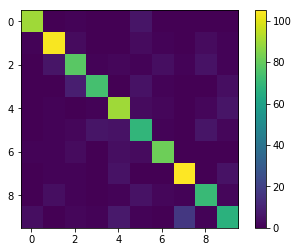

In [68]:
plt.imshow(conf_mx)
plt.colorbar();

In [69]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

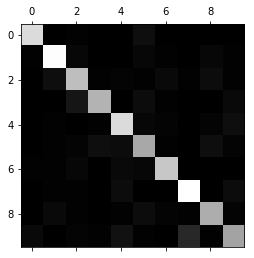

In [70]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

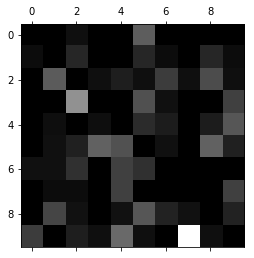

In [72]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

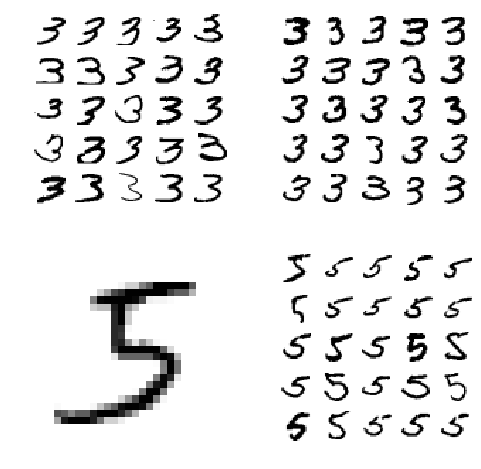

In [73]:
y_train_pred = sgd_clf.predict(X_train_scaled)

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel classification

In [1]:
# Two classifications, larger than 7 or if it is even or odd
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

NameError: name 'y_train' is not defined

In [75]:
knn_clf.predict(X_train[:4])

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [76]:
y_train_knn_pred = knn_clf.predict(X_train[:100])
f1_score(y_multilabel[:100], y_train_knn_pred, average="macro")

0.9862775751259336

# Multioutput classification

In [77]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

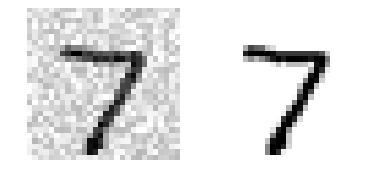

In [78]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

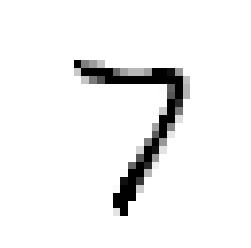

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)